<a href="https://colab.research.google.com/github/meliskarayigit/Istanbul-Weather-Forecasting/blob/main/Istanbul_Weather_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: Istanbul Weather Forecasting

# Imports

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 13.2 MB/s eta 0:00:00


In [ ]:
import random, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from keras_tuner import HyperModel, HyperParameters
from keras_tuner.tuners import RandomSearch

random.seed(46)
np.random.seed(46)
tf.random.set_seed(46)


# Functions

In [ ]:
def load_and_preprocess(data_path):
    data = pd.read_csv(data_path)
    data['temp_celsius'] = data['temp'] - 273.15
    # data['date'] = pd.to_datetime(data['dt_iso']).dt.date
    data['date'] = pd.to_datetime(data['dt_iso'], format='%Y-%m-%d %H:%M:%S +0000 UTC').dt.date
    data = data.drop(columns=['dt_iso', 'temp'])
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    return data.resample('D').mean()

def split_data_by_time(df, train_frac=0.7, val_frac=0.15):
    n = len(df)
    train_size = int(n * train_frac)
    val_size = int(n * val_frac)
    test_size = n - train_size - val_size
    train_df = df[:train_size]
    val_df = df[train_size:train_size+val_size]
    test_df = df[train_size+val_size:]
    return train_df, val_df, test_df


def scale_data(train_df, val_df, test_df, feature_columns, target_column):
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    scaler_x.fit(train_df[feature_columns])
    scaler_y.fit(train_df[[target_column]])
    train_x = scaler_x.transform(train_df[feature_columns])
    val_x = scaler_x.transform(val_df[feature_columns])
    test_x = scaler_x.transform(test_df[feature_columns])
    train_y = scaler_y.transform(train_df[[target_column]])
    val_y = scaler_y.transform(val_df[[target_column]])
    test_y = scaler_y.transform(test_df[[target_column]])
    return train_x, val_x, test_x, train_y.flatten(), val_y.flatten(), test_y.flatten(), scaler_x, scaler_y

def create_timewindow(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys), time_steps

def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()


def evaluate_predictions(model, X_train, y_train, X_val, y_val, X_test, y_test, scaler_y):

    y_train_pred_ = model.predict(X_train, verbose=0)
    y_val_pred = model.predict(X_val, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)

    true_y_train_pred = scaler_y.inverse_transform(y_train_pred_)
    true_y_val_pred = scaler_y.inverse_transform(y_val_pred)
    true_y_test_pred = scaler_y.inverse_transform(y_test_pred)

    true_y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))
    true_y_val = scaler_y.inverse_transform(y_val.reshape(-1, 1))
    true_y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    train_mse = mean_squared_error(true_y_train, true_y_train_pred)
    val_mse = mean_squared_error(true_y_val, true_y_val_pred)
    test_mse = mean_squared_error(true_y_test, true_y_test_pred)
    print("Train MSE:", train_mse, "Validation MSE:", val_mse, "Test MSE:", test_mse)
    return true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse


def plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps):
    plt.figure(dpi=200)
    plt.figure(figsize=(30, 10))
    # Train
    train_time = train_df.index[time_steps:]
    plt.plot(train_time, true_y_train, label='True Values (Train)', color='blue')
    plt.plot(train_time, true_y_train_pred, '--', label='Predicted Values (Train)', color='red')

    # Validation
    val_time = val_df.index[time_steps:]
    plt.plot(val_time, true_y_val, label='True Values (Validation)', color='green')
    plt.plot(val_time, true_y_val_pred, '--', label='Predicted Values (Validation)', color='orange')

    # Test
    test_time = test_df.index[time_steps:]
    plt.plot(test_time, true_y_test, label='True Values (Test)', color='purple')
    plt.plot(test_time, true_y_test_pred, '--', label='Predicted Values (Test)', color='pink')

    # Metrics
    plt.text(train_time.min(), true_y_train.max()*1.03, f"Train MSE: {train_mse:.4f}", fontsize=12)
    plt.text(train_time.min(), true_y_train.max()*0.98, f"Validation MSE: {val_mse:.4f}", fontsize=12)
    plt.text(train_time.min(), true_y_train.max()*0.93, f"Test MSE: {test_mse:.4f}", fontsize=12)

    plt.title('Actual and Predicted Values for All Data Sets')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_individual_series(data, figsize=(12, 4)):
    for column in data.columns:
        plt.figure(figsize=figsize)
        plt.plot(data.index, data[column], label=column, color='b')
        plt.title(f'Time Series Visualisation - {column}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.show()

# Data Set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/five_years_ist_weather.csv"

# Data Preparation

# Task 1: Perform data preprocessing steps.

- Read and preprocess the data

- Select features and target

- Split the dataset into train, validation, and test sets based on time

- Scale

- Create time windows

# Task 1 Solution

In [ ]:
df= load_and_preprocess(data_path)
print(df.head())

             humidity  wind_speed  clouds_all     pressure   dew_point  \
date                                                                     
2019-01-01  64.916667    5.473750   44.166667  1020.750000  273.427083   
2019-01-02  77.192308    3.921923   82.884615  1012.000000  275.625769   
2019-01-03  80.500000    5.600417   82.500000  1009.416667  275.659167   
2019-01-04  76.375000    7.986667   75.833333  1018.291667  272.872083   
2019-01-05  83.958333    6.635000   72.083333  1014.250000  274.025417   

            temp_celsius  
date                      
2019-01-01      6.390833  
2019-01-02      6.205000  
2019-01-03      5.622917  
2019-01-04      3.455833  
2019-01-05      3.334167  


In [ ]:
feature_columns=[col for col in df.columns if col !='temps_celsius']
target_column= 'temp_celsius'

#split data by time
train_df,val_df, test_df = split_data_by_time(df, train_frac=0.7,val_frac=0.15)
print("Train Sizes:", train_df.shape, "Validation Sizes:", val_df.shape, "Test Sizes:", test_df.shape)

#scaling
train_scaled_x, val_scaled_x, test_scaled_x, train_scaled_y, val_scaled_y, test_scaled_y, scaler_x, scaler_y = scale_data(train_df, val_df, test_df, feature_columns,target_column)

#time window
X_train,y_train,time_steps= create_timewindow(train_scaled_x,train_scaled_y, time_steps=10)
X_val,y_val, time_steps=create_timewindow(val_scaled_x, val_scaled_y,time_steps =10)
X_test, y_test, time_steps=create_timewindow(test_scaled_x, test_scaled_y, time_steps=10)

input_shape=(X_train.shape[1], X_train.shape[2])

Train Sizes: (1278, 6) Validation Sizes: (273, 6) Test Sizes: (275, 6)


# Task 2: Analyze the dataset.

- Descriptive statistics of the variables

- What is the standard deviation of Istanbul's average air temperature?

- Visualize the variables separately.

- Note: There is no need to examine anomalies and correlations.

# Task 2 Solution

In [ ]:
df.shape

(1826, 6)

In [ ]:
df.describe()

,humidity,wind_speed,clouds_all,pressure,dew_point,temp_celsius
count,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000
mean,70.896901,4.582238,31.097616,1015.936498,283.720919,16.221721
std,9.580190,1.858030,26.046656,6.175962,6.209948,7.202862
min,36.541667,0.792917,0.000000,991.625000,267.150000,-1.631667
25%,64.218750,3.150833,6.666667,1011.708333,279.051354,10.346979
50%,71.041667,4.401458,24.895833,1015.458333,283.752981,15.866042
75%,77.875000,5.763333,53.750000,1019.489583,288.946458,22.889479
max,96.750000,13.983333,100.000000,1038.750000,296.479167,31.163750


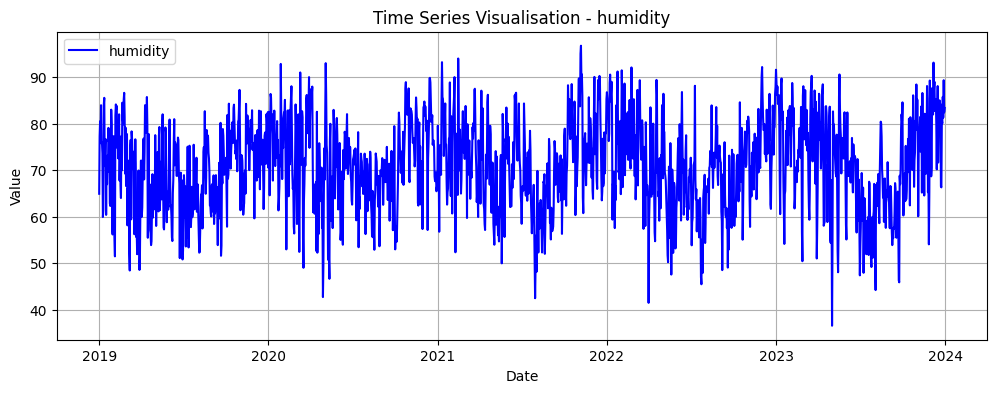

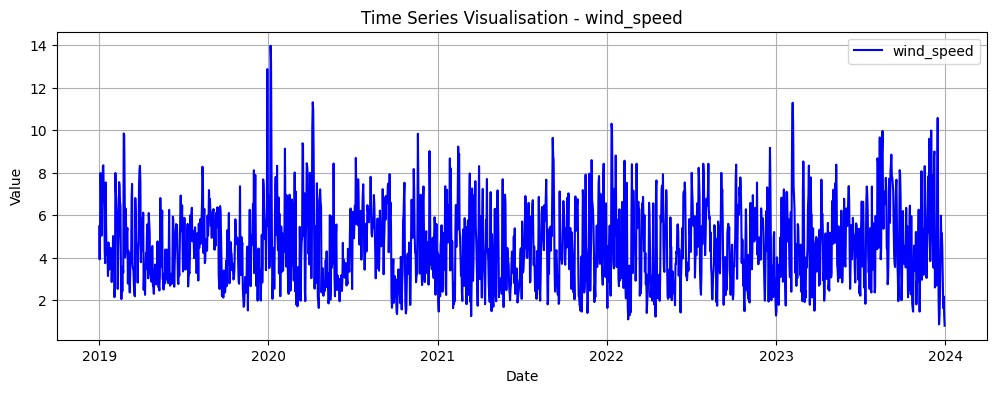

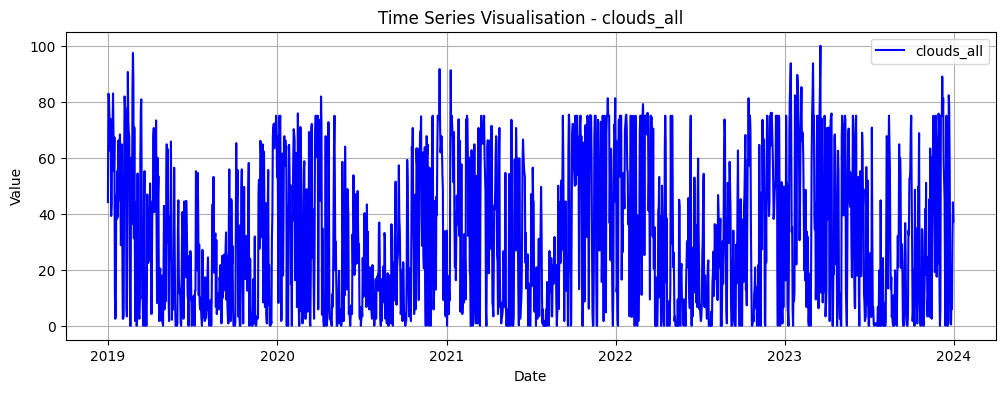

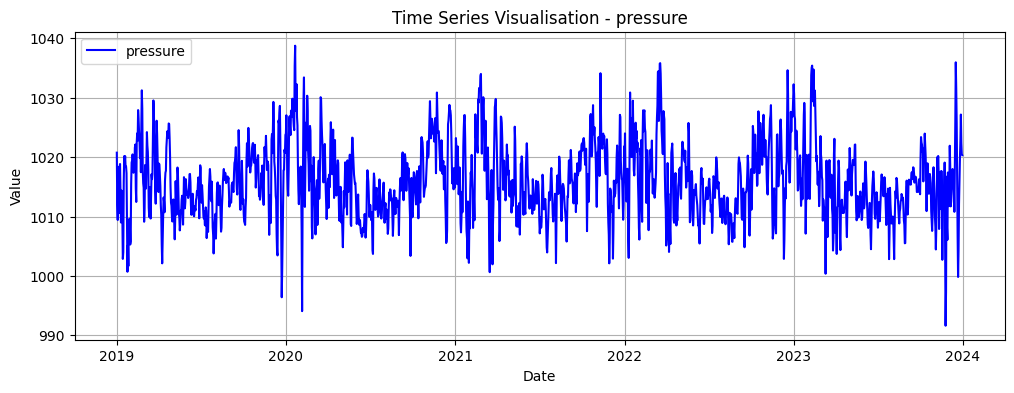

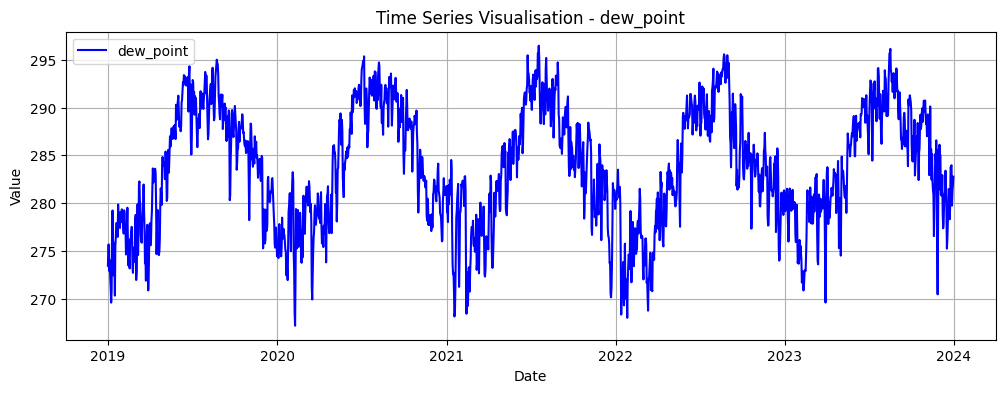

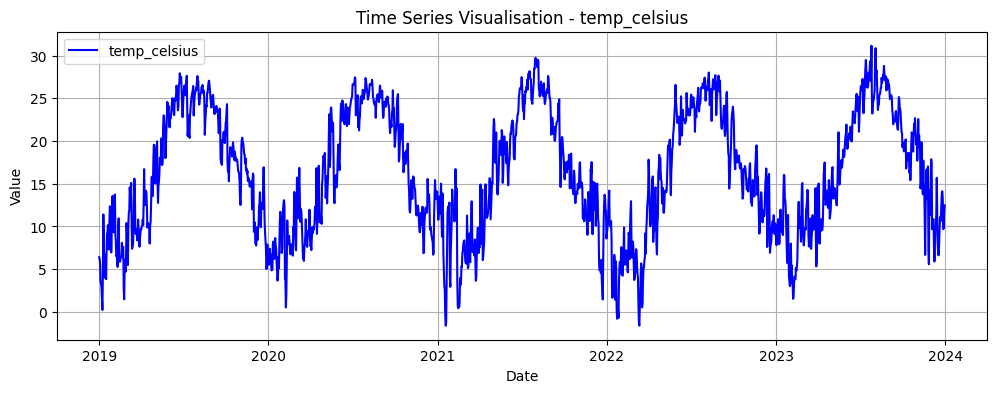

In [ ]:
plot_individual_series(df)

# Model

# Task 3: Build a simple LSTM model. You can make any adjustments you want.

# Task 3 Solution

In [ ]:
input_shape= (X_train.shape[1], X_train.shape[2])

model=Sequential([
    LSTM(50,input_shape=input_shape,
    kernel_regularizer=l2(0.001)),
    Dense(1)
])

optimizer=Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mse'])

model.summary()

early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True
    )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,451 (44.73 KB)

 Trainable params: 11,451 (44.73 KB)

 Non-trainable params: 0 (0.00 B)

# Task 4: Train the model. You can make any adjustments you want.

# Task 4 Solution

In [ ]:
start_time= datetime.datetime.now()

history=model.fit(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_val, y_val),
    batch_size=32,
    verbose=1,
    callbacks=early_stopping
)

end_time=datetime.datetime.now()

total_time_duartion=end_time-  start_time
print("Training Time:", total_time_duartion)

Epoch 1/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2074 - mse: 0.1957 - val_loss: 0.0270 - val_mse: 0.0159
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0231 - mse: 0.0123 - val_loss: 0.0176 - val_mse: 0.0076
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0182 - mse: 0.0086 - val_loss: 0.0154 - val_mse: 0.0067
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0159 - mse: 0.0075 - val_loss: 0.0137 - val_mse: 0.0060
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0142 - mse: 0.0068 - val_loss: 0.0124 - val_mse: 0.0056
Epoch 6/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0128 - mse: 0.0062 - val_loss: 0.0113 - val_mse: 0.0053
Epoch 7/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0117 - mse: 0.0057 - val_loss: 0.0105 - val_mse: 0.0050
Epoch 8/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0107 - mse: 0.0054 - val_loss: 0.0099 - val_mse: 0.0049
Epoch 9/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - l

# Performance Evaluation

# Task 5: Evaluate the model performance.

# Task 5 Solution

In [ ]:
train_loss=model.evaluate(X_train,y_train,verbose=0)
val_loss=model.evaluate(X_val,y_val,verbose=0)
test_loss=model.evaluate(X_test,y_test,verbose=1)
# [0] → loss
# [1] → mse
print(f"Train Loss: {train_loss[0]}", f"Validation Loss: {val_loss[0]}", f"Test Loss: {test_loss[0]}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mse: 0.0023 
Train Loss: 0.0027822928968816996 Validation Loss: 0.0026567098684608936 Test Loss: 0.003193484153598547


In [ ]:
true_y_train, true_y_train_pred, true_y_val, true_y_val_pred,true_y_test,true_y_test_pred,train_mse, val_mse, test_mse = evaluate_predictions(model, X_train, y_train, X_val, y_val, X_test, y_test, scaler_y)

Train MSE: 2.5550839405120853 Validation MSE: 2.43134546557612 Test MSE: 2.9602326100569036


<Figure size 1280x960 with 0 Axes>

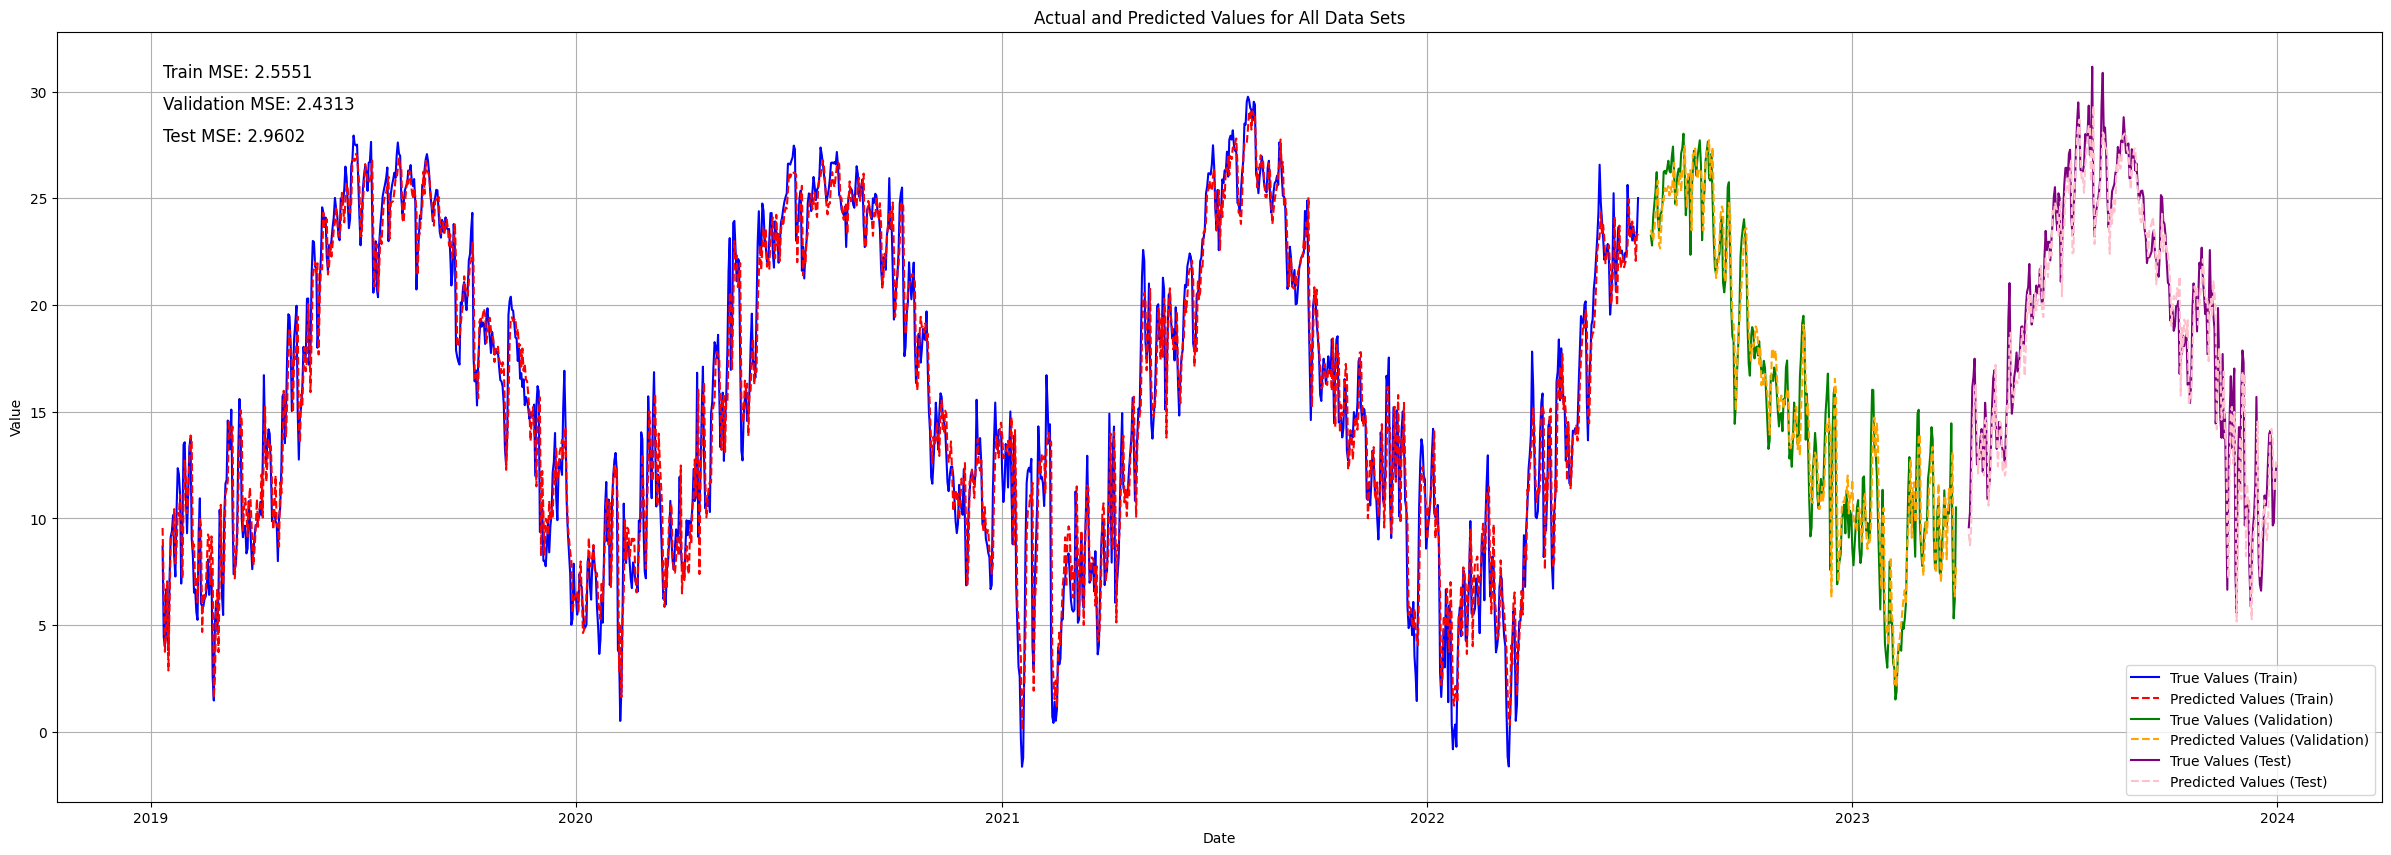

In [ ]:
plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps)

In [ ]:
true_y_test[-10:]

array([[10.59791667],
       [11.23833333],
       [12.77416667],
       [13.96375   ],
       [14.11958333],
       [13.19083333],
       [ 9.67125   ],
       [ 9.805     ],
       [11.74291667],
       [12.46875   ]])

In [ ]:
true_y_test_pred[-10:]

array([[ 9.509435],
       [ 8.982634],
       [ 9.650408],
       [12.672468],
       [14.104265],
       [14.194655],
       [13.757832],
       [11.311173],
       [11.292702],
       [12.665551]], dtype=float32)

# Hyperparameter Optimization

# Task 6: Prepare the hyperparameter search space for GRU.

- Number of layers: 10

- Number of neurons: From 16 to 1024 in increments of 32. (Don't forget to adjust the return_sequences section accordingly)

- Dropout: Between 0.0 and 0.5 in increments of 0.1.

- Initial learning rate for Adam between 1e-5 and 1e-2.

- You can also make any other adjustments you wish.

# Task 6 Solution

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=input_shape))

    for i in range(hp.Int('num_layers', 1, 10)):
        model.add(GRU(units=hp.Int('units_' + str(i), min_value=16, max_value=1024, step=32),
                      return_sequences=(i < hp.Int('num_layers', 1, 10) - 1)))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-2, sampling='LOG')),
                  loss='mean_squared_error',
                  metrics=['mse'])

    return model

# Task 7: Random Search Tuner ve Early Stopping yapılarını oluşturarak aramayı başladınız.

# Task 7 Solution

In [ ]:
random_search_tuner=RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='gru_tuning',
    overwrite=True
)

early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

random_search_tuner.search(X_train,y_train,
                           epochs=250,
                           validation_data=(X_val,y_val),
                           callbacks=[early_stopping])

Trial 20 Complete [00h 00m 14s]
val_loss: 0.025630833581089973

Best val_loss So Far: 0.003369357902556658
Total elapsed time: 00h 09m 58s


In [ ]:
random_search_tuner.results_summary()

Results summary
Results in hyperparam_tuning/gru_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 04 summary
Hyperparameters:
num_layers: 1
units_0: 752
dropout_0: 0.1
learning_rate: 0.0007967588627968657
units_1: 976
dropout_1: 0.4
units_2: 848
dropout_2: 0.2
units_3: 528
dropout_3: 0.1
units_4: 560
dropout_4: 0.1
Score: 0.003369357902556658

Trial 06 summary
Hyperparameters:
num_layers: 2
units_0: 208
dropout_0: 0.4
learning_rate: 0.0011537089634382357
units_1: 560
dropout_1: 0.30000000000000004
units_2: 368
dropout_2: 0.1
units_3: 208
dropout_3: 0.2
units_4: 816
dropout_4: 0.0
units_5: 1008
dropout_5: 0.30000000000000004
units_6: 400
dropout_6: 0.2
units_7: 112
dropout_7: 0.1
Score: 0.004429167602211237

Trial 08 summary
Hyperparameters:
num_layers: 2
units_0: 944
dropout_0: 0.0
learning_rate: 0.006157550009270945
units_1: 272
dropout_1: 0.0
units_2: 464
dropout_2: 0.30000000000000004
units_3: 976
dropout_3: 0.2
units_4: 432
dropout_4: 0.2
units_5: 94

# Task 8: Select the best model and evaluate its performance.

# Task 8 Solution

In [ ]:
best_hps=random_search_tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
def print_hyperparameter(hyperparameters):
  hp_df=pd.DataFrame(list(hyperparameters.items()),columns=['Hyperparameter','Value'])
  print(hp_df)

In [ ]:
print_hyperparameter(best_hps.values)

   Hyperparameter       Value
0      num_layers    1.000000
1         units_0  752.000000
2       dropout_0    0.100000
3   learning_rate    0.000797
4         units_1  976.000000
5       dropout_1    0.400000
6         units_2  848.000000
7       dropout_2    0.200000
8         units_3  528.000000
9       dropout_3    0.100000
10        units_4  560.000000
11      dropout_4    0.100000


In [ ]:
from joblib import dump
dump(best_hps, 'best_hps_gru.joblib')

['best_hps_gru.joblib']

In [ ]:
best_model=random_search_tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 752)            │     1,714,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 752)            │         3,008 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 752)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           753 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,718,321 (6.55 MB)

 Trainable params: 1,716,817 (6.55 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [ ]:
train_loss = best_model.evaluate(X_train, y_train, verbose=0)
val_loss = best_model.evaluate(X_val, y_val, verbose=0)
test_loss = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss[0]}", f"Validation Loss: {val_loss[0]}", f"Test Loss: {test_loss[0]}")

Train Loss: 0.003283950500190258 Validation Loss: 0.003369357902556658 Test Loss: 0.0038776430301368237


In [ ]:
best_model.save('weather_forecast_gru_tuned.keras')

In [ ]:
true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse = evaluate_predictions(best_model, X_train, y_train, X_val, y_val, X_test, y_test, scaler_y)

Train MSE: 3.2356955573002 Validation MSE: 3.319848343044547 Test MSE: 3.8206643519486327


<Figure size 1280x960 with 0 Axes>

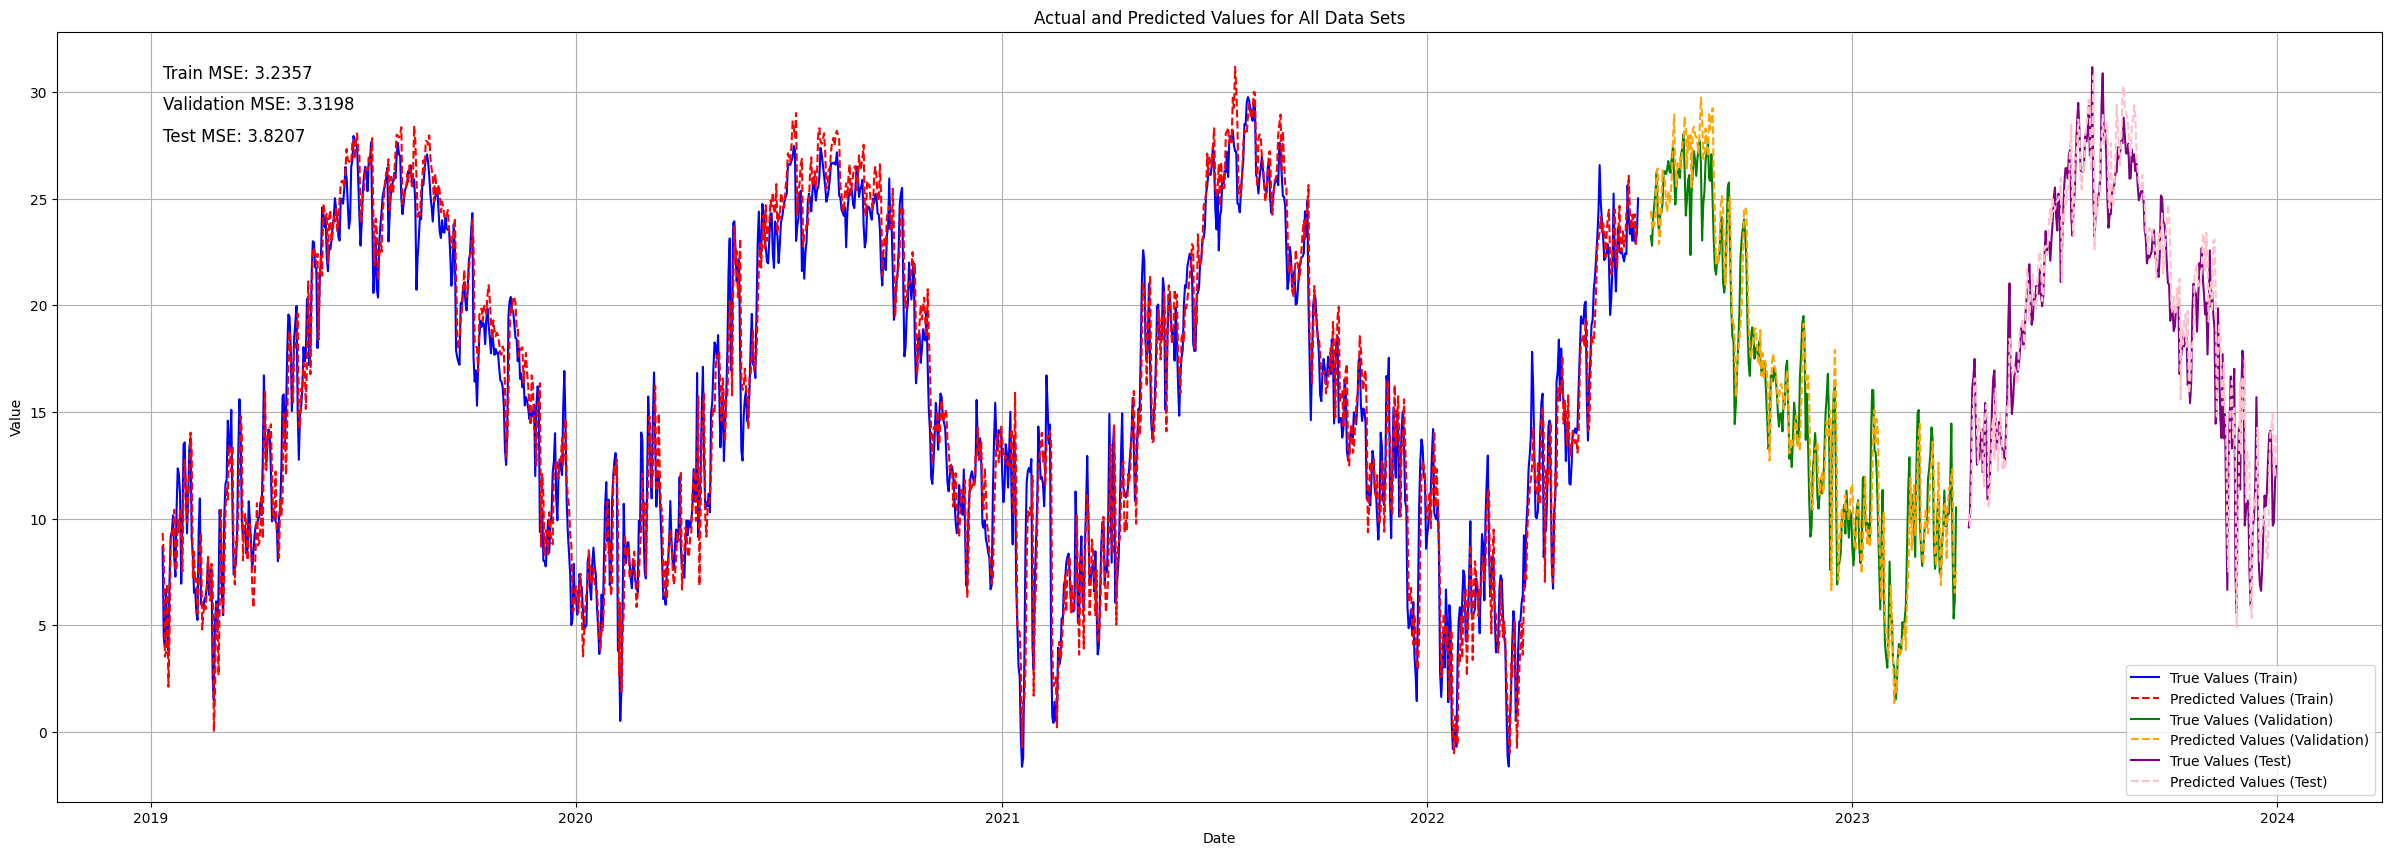

In [ ]:
plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps)